In [1]:
import sys
sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

np.random.seed(1234)
tf.set_random_seed(1234)

%matplotlib inline

/home/xiang/miniconda3/envs/ML/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X, u, X_ib, u_ib, layers, lb, ub):
        
        self.lb = lb
        self.ub = ub
        
        self.x = X[:,0:1]
        self.t = X[:,1:2]
        self.u = u
        
        self.x_ib = X_ib[:,0:1]
        self.t_ib = X_ib[:,1:2]
        self.u_ib = u_ib
        
        self.layers = layers
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([-6.0], dtype=tf.float32)
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.u_pred = self.net_u(self.x_tf, self.t_tf)
        self.f_pred = self.net_f(self.x_tf, self.t_tf)
        
        self.x_ib_tf = tf.placeholder(tf.float32, shape=[None, self.x_ib.shape[1]])
        self.t_ib_tf = tf.placeholder(tf.float32, shape=[None, self.t_ib.shape[1]])
        self.u_ib_tf = tf.placeholder(tf.float32, shape=[None, self.u_ib.shape[1]])
        self.u_ib_pred = self.net_u(self.x_ib_tf, self.t_ib_tf)
        
        
        #self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
        #            tf.reduce_mean(tf.square(self.f_pred))*10000
        self.loss = tf.reduce_mean(tf.square(self.u_ib_tf - self.u_ib_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))*100

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate=0.002)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):  
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x, t):
        lambda_1 = self.lambda_1        
        lambda_2 = tf.exp(self.lambda_2)
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = u_t + lambda_1*u*u_x - lambda_2*u_xx
        
        return f
    
    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, lambda_1, np.exp(lambda_2)))
        
        
    def train(self, nIter, train_withBFGS = True):
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u,\
                  self.x_ib_tf: self.x_ib, self.t_ib_tf: self.t_ib, self.u_ib_tf: self.u_ib}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = np.exp(self.sess.run(self.lambda_2))
                print('It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
                start_time = time.time()
        
        if (train_withBFGS):
            self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.lambda_1, self.lambda_2],
                                loss_callback = self.callback)
        
        
    def predict(self, X_star):
        
        tf_dict = {self.x_tf: X_star[:,0:1], self.t_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        f_star = self.sess.run(self.f_pred, tf_dict)
        
        return u_star, f_star


In [3]:
nu = 0.01/np.pi

N_u = 1000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('../Data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

## Noiseless Data



In [4]:
noise = 0.0            
#choose random points to reinforce u to converge to real solution             
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
#choose initial condition and boundary condition
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

idx_ib = list(range(256)) + [i*256+j for i in range(1,len(t)) for j in [0,255]]
print('length of control points for initial condition and boundary condition: %d' % len(idx))
X_u_train_ib = X_star[idx_ib,:]
u_train_ib = u_star[idx_ib,:]
T,X = np.meshgrid(t,x)

length of control points for initial condition and boundary condition: 1000


Text(0,0.5,'x')

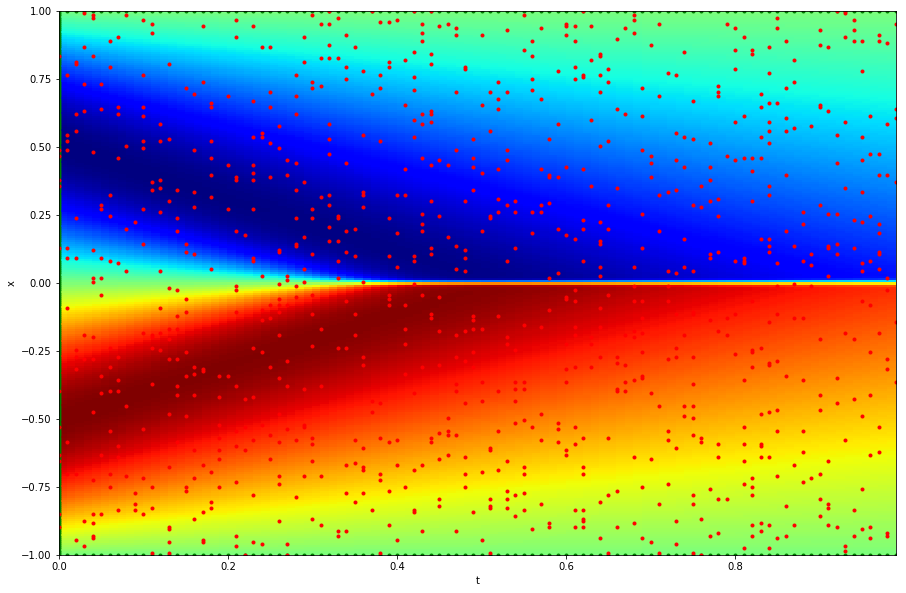

In [5]:
fig = plt.figure(figsize=(15,10))
plt.pcolor(T,X,Exact.T,cmap='jet')
plt.plot(X_u_train_ib[:,1],X_u_train_ib[:,0],'g.')
plt.plot(X_u_train[:,1],X_u_train[:,0],'r.')
plt.xlabel('t')
plt.ylabel('x')


In [6]:
model = PhysicsInformedNN(X_u_train, u_train, X_u_train_ib, u_train_ib, layers, lb, ub)

In [7]:
model.train(0, True)

Loss: 8.730237e-01, l1: 0.00000, l2: 0.00248
Loss: 1.252136e+00, l1: -0.00002, l2: 0.00248
Loss: 2.747676e+00, l1: -0.00001, l2: 0.00248
Loss: 3.847219e-01, l1: -0.00000, l2: 0.00248
Loss: 3.150490e-01, l1: -0.00000, l2: 0.00248
Loss: 3.085971e-01, l1: -0.00000, l2: 0.00248
Loss: 3.062277e-01, l1: -0.00000, l2: 0.00248
Loss: 2.916425e-01, l1: 0.00000, l2: 0.00248
Loss: 2.769861e-01, l1: 0.00000, l2: 0.00248
Loss: 2.757941e-01, l1: 0.00000, l2: 0.00248
Loss: 2.746227e-01, l1: 0.00000, l2: 0.00248
Loss: 2.737916e-01, l1: 0.00000, l2: 0.00248
Loss: 2.699266e-01, l1: 0.00001, l2: 0.00248
Loss: 2.637937e-01, l1: 0.00001, l2: 0.00248
Loss: 2.521958e-01, l1: 0.00001, l2: 0.00248
Loss: 2.399890e-01, l1: 0.00000, l2: 0.00248
Loss: 2.350873e-01, l1: -0.00003, l2: 0.00248
Loss: 2.279696e-01, l1: -0.00006, l2: 0.00248
Loss: 2.217533e-01, l1: -0.00041, l2: 0.00248
Loss: 2.361112e-01, l1: -0.00150, l2: 0.00248
Loss: 2.198593e-01, l1: -0.00071, l2: 0.00248
Loss: 2.195396e-01, l1: -0.00089, l2: 0.0024

Loss: 5.343862e-03, l1: 0.00138, l2: 0.00235
Loss: 4.850287e-03, l1: 0.00163, l2: 0.00236
Loss: 4.532905e-03, l1: 0.00128, l2: 0.00236
Loss: 6.435615e-03, l1: 0.00181, l2: 0.00235
Loss: 4.420383e-03, l1: 0.00139, l2: 0.00236
Loss: 3.999689e-03, l1: 0.00171, l2: 0.00235
Loss: 4.577155e-03, l1: 0.00205, l2: 0.00235
Loss: 3.737159e-03, l1: 0.00184, l2: 0.00235
Loss: 3.496590e-03, l1: 0.00210, l2: 0.00235
Loss: 3.790155e-03, l1: 0.00199, l2: 0.00235
Loss: 3.396658e-03, l1: 0.00206, l2: 0.00235
Loss: 3.406391e-03, l1: 0.00181, l2: 0.00235
Loss: 3.222133e-03, l1: 0.00193, l2: 0.00235
Loss: 2.909786e-03, l1: 0.00201, l2: 0.00235
Loss: 2.743078e-03, l1: 0.00226, l2: 0.00236
Loss: 2.441808e-03, l1: 0.00207, l2: 0.00236
Loss: 2.454222e-03, l1: 0.00190, l2: 0.00236
Loss: 2.327868e-03, l1: 0.00198, l2: 0.00236
Loss: 2.184543e-03, l1: 0.00185, l2: 0.00236
Loss: 2.048420e-03, l1: 0.00174, l2: 0.00236
Loss: 1.882639e-03, l1: 0.00227, l2: 0.00236
Loss: 1.935079e-03, l1: 0.00236, l2: 0.00236
Loss: 1.77

Loss: 1.865717e-04, l1: 0.00034, l2: 0.00234
Loss: 1.862253e-04, l1: 0.00033, l2: 0.00234
Loss: 1.859209e-04, l1: 0.00032, l2: 0.00234
Loss: 1.855569e-04, l1: 0.00029, l2: 0.00234
Loss: 1.851653e-04, l1: 0.00028, l2: 0.00234
Loss: 1.848887e-04, l1: 0.00027, l2: 0.00234
Loss: 1.848119e-04, l1: 0.00026, l2: 0.00234
Loss: 1.847607e-04, l1: 0.00023, l2: 0.00234
Loss: 1.846742e-04, l1: 0.00023, l2: 0.00234
Loss: 1.846021e-04, l1: 0.00022, l2: 0.00234
Loss: 1.845308e-04, l1: 0.00020, l2: 0.00234
Loss: 1.844760e-04, l1: 0.00019, l2: 0.00234
Loss: 1.844157e-04, l1: 0.00019, l2: 0.00234
Loss: 1.843372e-04, l1: 0.00019, l2: 0.00234
Loss: 1.842893e-04, l1: 0.00017, l2: 0.00234
Loss: 1.841814e-04, l1: 0.00017, l2: 0.00234
Loss: 1.840676e-04, l1: 0.00016, l2: 0.00234
Loss: 1.838396e-04, l1: 0.00012, l2: 0.00234
Loss: 1.834301e-04, l1: 0.00009, l2: 0.00234
Loss: 1.824339e-04, l1: -0.00001, l2: 0.00234
Loss: 1.826900e-04, l1: -0.00012, l2: 0.00234
Loss: 1.814531e-04, l1: -0.00006, l2: 0.00234
Loss: 1

Loss: 6.743734e-05, l1: -0.00049, l2: 0.00234
Loss: 6.699846e-05, l1: -0.00051, l2: 0.00234
Loss: 6.675119e-05, l1: -0.00051, l2: 0.00234
Loss: 6.666507e-05, l1: -0.00051, l2: 0.00234
Loss: 6.648662e-05, l1: -0.00052, l2: 0.00234
Loss: 6.639570e-05, l1: -0.00051, l2: 0.00234
Loss: 6.632260e-05, l1: -0.00051, l2: 0.00234
Loss: 6.622789e-05, l1: -0.00051, l2: 0.00234
Loss: 6.616114e-05, l1: -0.00050, l2: 0.00234
Loss: 6.611834e-05, l1: -0.00050, l2: 0.00234
Loss: 6.607073e-05, l1: -0.00050, l2: 0.00234
Loss: 6.601721e-05, l1: -0.00049, l2: 0.00234
Loss: 6.595184e-05, l1: -0.00048, l2: 0.00234
Loss: 6.586291e-05, l1: -0.00046, l2: 0.00234
Loss: 6.573588e-05, l1: -0.00044, l2: 0.00234
Loss: 6.542230e-05, l1: -0.00039, l2: 0.00234
Loss: 6.529738e-05, l1: -0.00038, l2: 0.00234
Loss: 6.505285e-05, l1: -0.00039, l2: 0.00234
Loss: 6.485826e-05, l1: -0.00039, l2: 0.00234
Loss: 6.463036e-05, l1: -0.00039, l2: 0.00234
Loss: 6.416511e-05, l1: -0.00037, l2: 0.00234
Loss: 6.382533e-05, l1: -0.00033, 

Loss: 3.466074e-05, l1: 0.00024, l2: 0.00234
Loss: 3.470944e-05, l1: 0.00024, l2: 0.00234
Loss: 3.464826e-05, l1: 0.00024, l2: 0.00234
Loss: 3.463756e-05, l1: 0.00024, l2: 0.00234
Loss: 3.463833e-05, l1: 0.00025, l2: 0.00234
Loss: 3.462982e-05, l1: 0.00024, l2: 0.00234
Loss: 3.461443e-05, l1: 0.00025, l2: 0.00234
Loss: 3.459115e-05, l1: 0.00024, l2: 0.00234
Loss: 3.457339e-05, l1: 0.00025, l2: 0.00234
Loss: 3.455636e-05, l1: 0.00025, l2: 0.00234
Loss: 3.459349e-05, l1: 0.00024, l2: 0.00234
Loss: 3.454379e-05, l1: 0.00025, l2: 0.00234
Loss: 3.450998e-05, l1: 0.00025, l2: 0.00234
Loss: 3.442914e-05, l1: 0.00025, l2: 0.00234
Loss: 3.438499e-05, l1: 0.00023, l2: 0.00234
Loss: 3.435608e-05, l1: 0.00021, l2: 0.00234
Loss: 3.425648e-05, l1: 0.00022, l2: 0.00234
Loss: 3.422408e-05, l1: 0.00022, l2: 0.00234
Loss: 3.420136e-05, l1: 0.00022, l2: 0.00234
Loss: 3.418159e-05, l1: 0.00023, l2: 0.00234
Loss: 3.415649e-05, l1: 0.00024, l2: 0.00234
Loss: 3.411740e-05, l1: 0.00025, l2: 0.00234
Loss: 3.40

Loss: 3.156896e-05, l1: 0.00035, l2: 0.00234
Loss: 3.156730e-05, l1: 0.00035, l2: 0.00234
Loss: 3.156650e-05, l1: 0.00035, l2: 0.00234
Loss: 3.156714e-05, l1: 0.00036, l2: 0.00234
Loss: 3.156644e-05, l1: 0.00035, l2: 0.00234
Loss: 3.161823e-05, l1: 0.00037, l2: 0.00234
Loss: 3.156548e-05, l1: 0.00035, l2: 0.00234
Loss: 3.156520e-05, l1: 0.00035, l2: 0.00234
Loss: 3.156493e-05, l1: 0.00035, l2: 0.00234
Loss: 3.156454e-05, l1: 0.00035, l2: 0.00234
Loss: 3.156329e-05, l1: 0.00035, l2: 0.00234
Loss: 3.156125e-05, l1: 0.00036, l2: 0.00234
Loss: 3.156197e-05, l1: 0.00036, l2: 0.00234
Loss: 3.156182e-05, l1: 0.00036, l2: 0.00234
Loss: 3.156200e-05, l1: 0.00036, l2: 0.00234
Loss: 3.156120e-05, l1: 0.00036, l2: 0.00234
Loss: 3.156151e-05, l1: 0.00036, l2: 0.00234
Loss: 3.156120e-05, l1: 0.00036, l2: 0.00234
Loss: 3.156120e-05, l1: 0.00036, l2: 0.00234
Loss: 3.156146e-05, l1: 0.00036, l2: 0.00234
Loss: 3.156120e-05, l1: 0.00036, l2: 0.00234
Loss: 3.156120e-05, l1: 0.00036, l2: 0.00234
Loss: 3.15

In [8]:
u_pred, f_pred = model.predict(X_star)


In [9]:
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)


In [10]:
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')


In [11]:

lambda_1_value = model.sess.run(model.lambda_1)
lambda_2_value = model.sess.run(model.lambda_2)
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0)*100
error_lambda_2 = np.abs(lambda_2_value - nu)/nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  


Error u: 5.751633e-01
Error l1: 99.96430%
Error l2: 26.52602%


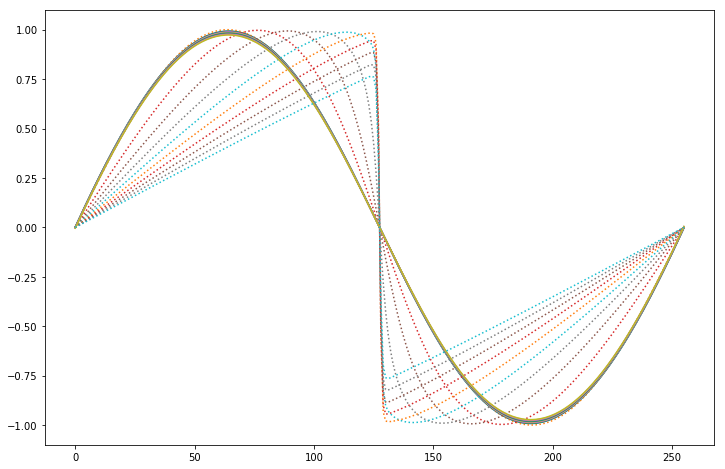

In [12]:
plt.figure(figsize=(12,8))
for tmp_i in range(0,t.shape[0],10):
    tmp_t = t[tmp_i]
    tmp_x_t = np.concatenate((x,np.full(x.shape,tmp_t)),1)
    tmp_u_pred, _ = model.predict(tmp_x_t)
    
    plt.plot(tmp_u_pred)
    plt.plot(Exact[tmp_i,:],':')

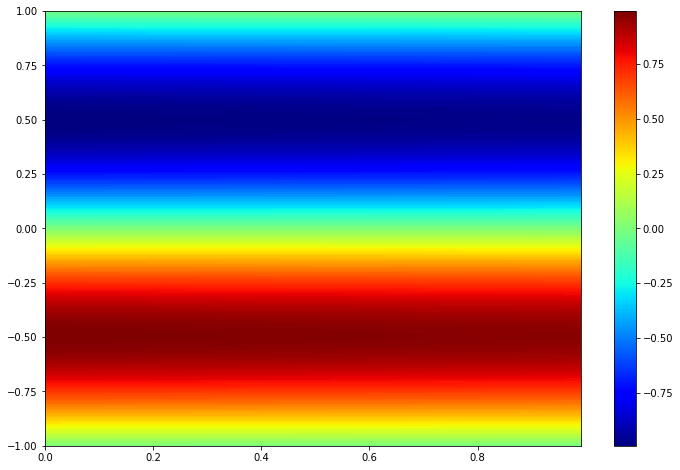

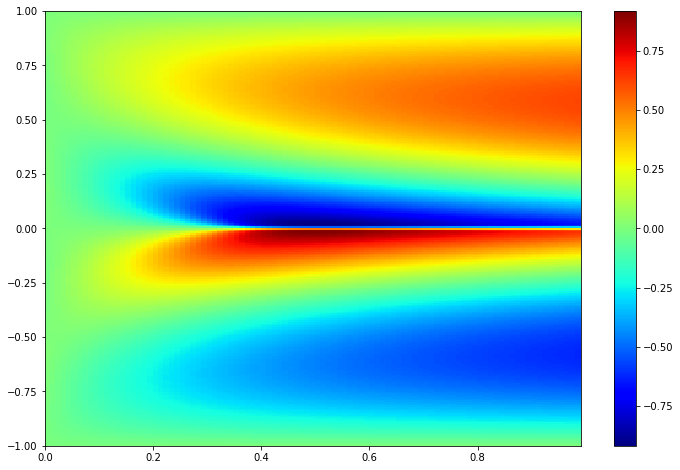

In [13]:
plt.figure(figsize=(12,8))
plt.pcolor(T,X,U_pred,cmap='jet')
plt.colorbar()

plt.figure(figsize=(12,8))
plt.pcolor(T,X,Exact.T-U_pred,cmap='jet')
plt.colorbar()